# Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали я буду строить модель, которая предскажет температуру стали.

### Ключевые этапы:

1. Выделить нужные данные из всех датасетов в один.
2. Добавить недостающие признаки.
3. Определить целевой признак.
4. Выбрать модели и обучить их, подбирая гиперпараметры через ...SearchCV.
5. Протестировать модель, показавшую лучшие результаты на тренировочной выборке.

## Анализ данных

### Что я знаю об обработке стали:
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Первым делом нужно ознакомиться с данными, которые у нас имеются.

In [1]:
#так как у меня не была установлена библиотека catboost в колабе, первым делом устанавливаю ее:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 120623

### В датасетах смотрю стат.показатели, графики распределения, пропуски, отсутствие данных.

**Данные об электродах:**
- нет пропусков,
- найден пик активной мощности
- понятно в каких пределах расположилась реакт.мощность. У нее ст.отклонение показателей в сравнении с акт.мощностью.

In [3]:
arc = pd.read_csv('/content/data_arc_new (1).csv')
display(arc.head())
arc.info()
arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Избавимся от вбросов:

[-715.479924]
(array([9780]),)


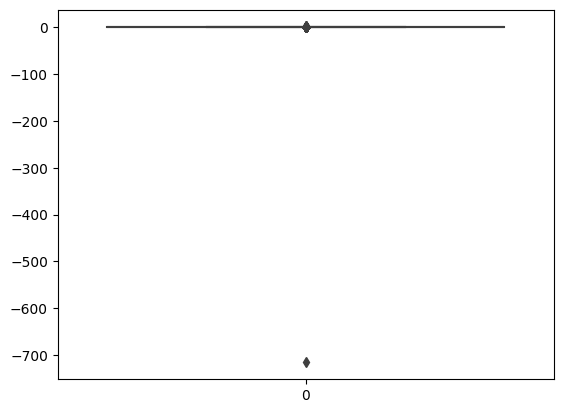

In [4]:
negative_nums = []
for num in arc['Реактивная мощность']:
    if num <= 0:
        negative_nums.append(num)

print(negative_nums)


sns.boxplot(arc['Реактивная мощность'])
print(np.where(arc['Реактивная мощность']<0))

In [5]:
arc = arc[arc['Реактивная мощность'] > 0]
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

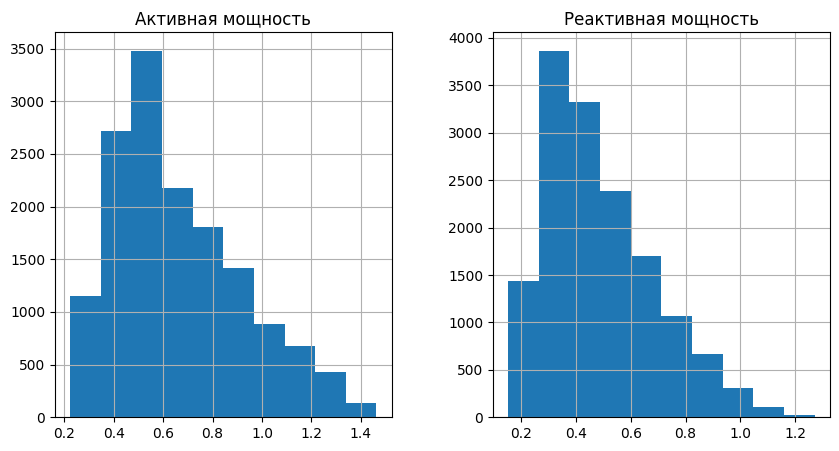

In [6]:
arc[['Активная мощность', 'Реактивная мощность']].hist(figsize=(10, 5));
arc.isna().sum()

Переведем время в соответсвующий тип данных:

In [7]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14875 non-null  int64         
 1   Начало нагрева дугой  14875 non-null  datetime64[ns]
 2   Конец нагрева дугой   14875 non-null  datetime64[ns]
 3   Активная мощность     14875 non-null  float64       
 4   Реактивная мощность   14875 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


Посчитаем длительность нагрева электрода в секундах

In [8]:
arc['work_arc'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой'])
arc['work_arc'] = arc['work_arc'].apply(lambda x: x.total_seconds())

display(arc.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,work_arc
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


Тут считаю разницу в ковше: замер начало нагрева и замер конец начала нагрева

In [9]:
arc_sum = arc.groupby('key').agg(time = ('work_arc', 'sum'), active_power = ('Активная мощность', 'sum'),
                                           reactive_power = ('Реактивная мощность', 'sum'))
arc_sum['full_power'] = np.sqrt(arc_sum['active_power']**2 + arc_sum['reactive_power']**2)

#arc_sum['work_power'] = arc['work_arc']  * arc_sum['full_power']
arc_sum['work_power'] = arc_sum['time']/arc_sum['full_power']
display(arc_sum.head())


,time,active_power,reactive_power,full_power,work_power
key,,,,,
1,1098.0,3.036730,2.142821,3.716640,295.428150
2,811.0,2.139408,1.453357,2.586371,313.566812
3,655.0,4.063641,2.937457,5.014163,130.629974
4,741.0,2.706489,2.056992,3.399456,217.976074
5,869.0,2.252950,1.687991,2.815155,308.686385


In [10]:
arc_sum['work_arc'] = arc['work_arc'] * arc_sum['full_power']
#arc_sum['work_arc'] = arc_sum['work_arc'].apply(lambda x: x.total_seconds())



display(arc_sum.head())

,time,active_power,reactive_power,full_power,work_power,work_arc
key,,,,,,
1,1098.0,3.036730,2.142821,3.716640,295.428150,687.578351
2,811.0,2.139408,1.453357,2.586371,313.566812,444.855752
3,655.0,4.063641,2.937457,5.014163,130.629974,1830.169539
4,741.0,2.706489,2.056992,3.399456,217.976074,503.119438
5,869.0,2.252950,1.687991,2.815155,308.686385,385.676226


In [11]:
good_arc = arc_sum[['full_power', 'work_power', 'work_arc']]
display(good_arc.head())

,full_power,work_power,work_arc
key,,,
1,3.716640,295.428150,687.578351
2,2.586371,313.566812,444.855752
3,5.014163,130.629974,1830.169539
4,3.399456,217.976074,503.119438
5,2.815155,308.686385,385.676226


**Данные о подаче сыпучих материалов, объём:**
- много пропусков и незаполненных данных. Похоже, что сып.материалы не понадобились.
- всего было 15 подач, средние показатели каждой подачи разные. Скорее всего это связяно с отсутствием данных.


In [12]:
bulk = pd.read_csv('/content/data_bulk_new (1).csv')
display(bulk.head())
bulk.info()
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

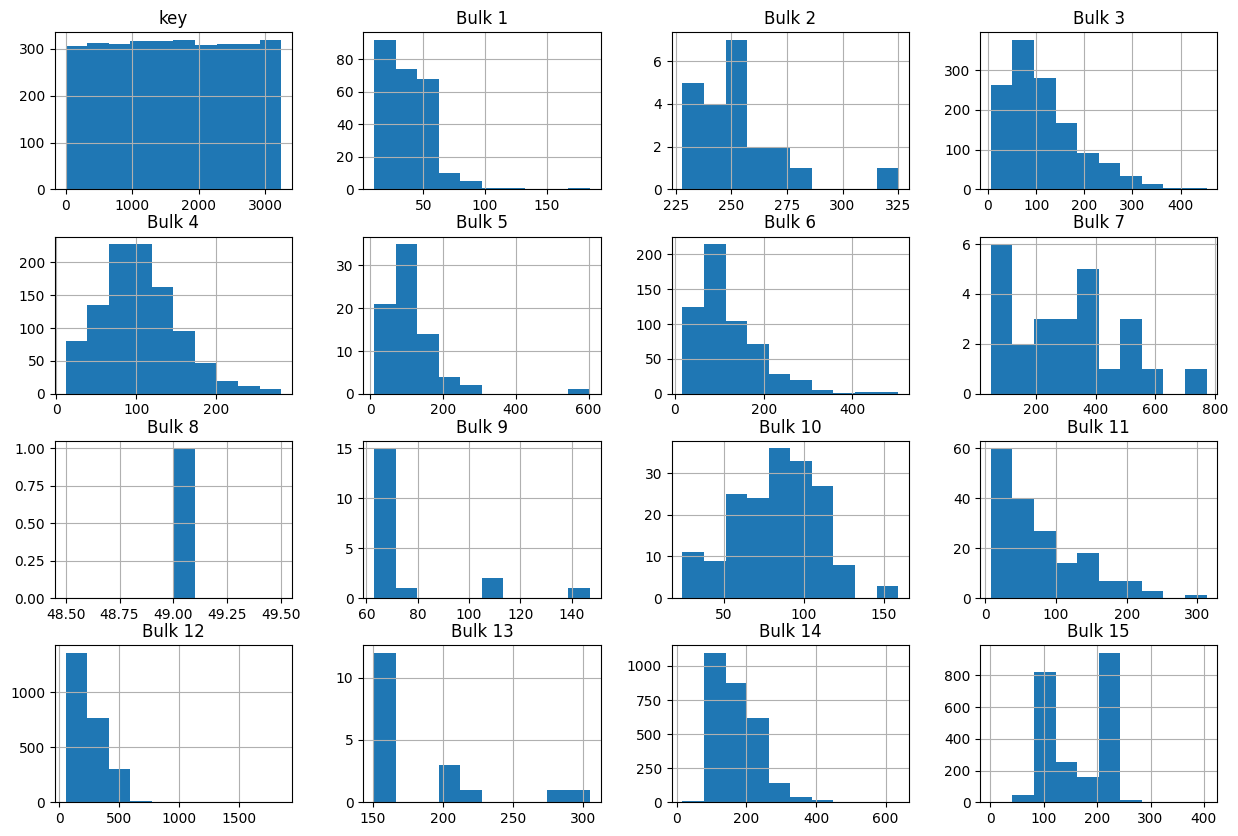

In [13]:
bulk.hist(figsize=(15, 10));

bulk.isna().sum()

Оставим те присыпки, в которых больше 500 значений. В которых от 100 до 500 объединим в один столбц:

In [14]:
bulk_ok=bulk[['key', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']]
#bulk_ok['bulk_sum_small'] = bulk['Bulk 1']+bulk['Bulk 10']+bulk['Bulk 11']
bulk_ok.fillna(0, inplace=True)

display(bulk_ok)

<ipython-input-14-dcaa12ae6e41>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bulk_ok.fillna(0, inplace=True)


,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,43.0,0.0,206.0,150.0,154.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0
3,4,0.0,81.0,0.0,207.0,153.0,154.0
4,5,0.0,78.0,0.0,203.0,151.0,152.0
...,...,...,...,...,...,...,...
3124,3237,170.0,0.0,0.0,252.0,130.0,206.0
3125,3238,126.0,0.0,0.0,254.0,108.0,106.0
3126,3239,0.0,0.0,114.0,158.0,270.0,88.0
3127,3240,0.0,0.0,26.0,0.0,192.0,54.0


**Данные о подаче сыпучих материалов, время:**
- ожидаемо данные есть только в тех случаях, когда была подача.

Описательная статистика здеьс не инфомративна.
Для построения графика нужно переводить данные в другой формат. Не ясно пригодятся ли мне для прогнозирования эти данные. Оставляю как есть.

In [15]:
bulk_time = pd.read_csv('/content/data_bulk_time_new (1).csv')
display(bulk_time.sample(10))

bulk_time.info()
bulk_time.isna().sum()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1527,1585,NaN,NaN,2019-07-02 00:34:52,NaN,NaN,2019-07-02 00:45:12,NaN,NaN,NaN,NaN,NaN,2019-07-02 00:34:52,NaN,2019-07-02 00:30:13,NaN
558,587,NaN,NaN,NaN,2019-05-25 18:53:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-25 18:51:15,NaN,2019-05-25 18:47:20,2019-05-25 18:40:24
171,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-10 16:13:39,2019-05-10 16:09:14
2973,3082,NaN,NaN,2019-09-01 06:42:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 06:52:52,NaN,2019-09-01 06:49:35,2019-09-01 06:42:21
2810,2916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-26 07:24:11,NaN,2019-08-26 07:20:09,2019-08-26 07:00:42,NaN,2019-08-26 06:58:03
2194,2273,NaN,NaN,NaN,NaN,NaN,2019-08-02 05:04:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-02 04:54:18,NaN
1015,1060,NaN,NaN,NaN,2019-06-13 05:24:41,NaN,NaN,NaN,NaN,NaN,2019-06-13 05:22:48,NaN,2019-06-13 05:24:41,NaN,2019-06-13 05:22:48,2019-06-13 05:03:56
996,1041,NaN,NaN,2019-06-12 13:12:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-12 13:06:10,NaN,2019-06-12 12:46:39,2019-06-12 12:40:35
506,534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-23 19:10:45,NaN,2019-05-23 19:10:45,2019-05-23 19:10:45
1389,1443,NaN,NaN,2019-06-26 14:40:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-26 15:08:56,NaN,2019-06-26 15:04:12,2019-06-26 14:54:13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Данные о продувке сплава газом:**
- датасет содержит 1 столбец,
- данные без пропусков,
- найден пик продувки

In [16]:
gas = pd.read_csv('/content/data_gas_new (1).csv')
display(gas.head())
gas.info()
gas['Газ 1'].describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

key      0
Газ 1    0
dtype: int64

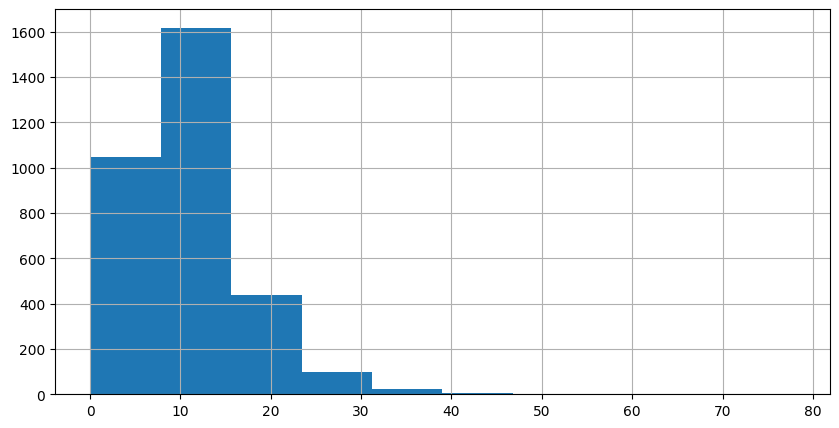

In [17]:
gas['Газ 1'].hist(figsize=(10, 5));
gas.isna().sum()

In [18]:
temp = pd.read_csv('/content/data_temp_new (1).csv')
temp.sort_index(inplace=True)
display(temp.index.is_monotonic)
temp.info()

display(temp.head())

<ipython-input-18-8c2f30c46871>:3: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  display(temp.index.is_monotonic)


True

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


**Результаты измерения температуры:**
- замер происходит примерно каждые 3-5 минут,
- есть пропуски значений температуры/

Для построения графика нужно переводить данные в другой формат. Не ясно пригодятся ли мне для прогнозирования эти данные. Оставляю как есть.

Найдем пустые значения в ковшах и удалим их:

In [19]:
len(temp[temp['Температура'].isnull()])
temp[temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [20]:
temp =  temp.query('key < 2500')
display(temp.head())
temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13926 non-null  int64  
 1   Время замера  13926 non-null  object 
 2   Температура   13926 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.2+ KB


count    13926.000000
mean      1590.802671
std         19.845377
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

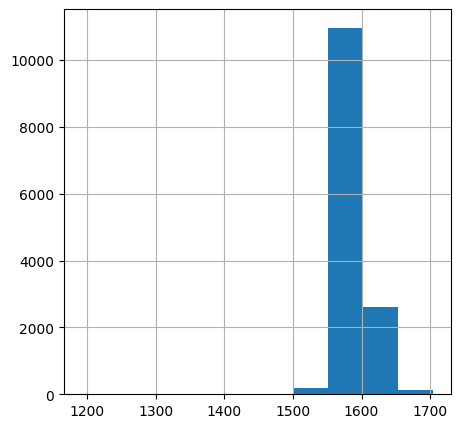

In [21]:
temp['Температура'].hist(figsize=(5, 5));
temp.isna().sum()
temp['Температура'].describe()

In [22]:
filtr_temp = temp.groupby('key').filter(lambda x: len(x) > 1)

display(filtr_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [23]:
good_temp_first = filtr_temp.groupby('key').head(1)
good_temp_last = filtr_temp.groupby('key').tail(1)

display(good_temp_first)
display(good_temp_last)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
6,2,2019-05-03 11:34:04,1581.0
11,3,2019-05-03 12:06:44,1596.0
17,4,2019-05-03 12:39:27,1601.0
22,5,2019-05-03 13:11:03,1576.0
...,...,...,...
13899,2495,2019-08-10 11:27:47,1570.0
13904,2496,2019-08-10 11:56:48,1554.0
13911,2497,2019-08-10 12:37:26,1571.0
13915,2498,2019-08-10 12:58:11,1591.0


,key,Время замера,Температура
5,1,2019-05-03 11:30:38,1613.0
10,2,2019-05-03 11:55:09,1602.0
16,3,2019-05-03 12:35:57,1599.0
21,4,2019-05-03 12:59:47,1625.0
26,5,2019-05-03 13:36:39,1602.0
...,...,...,...
13903,2495,2019-08-10 11:50:47,1591.0
13910,2496,2019-08-10 12:25:13,1591.0
13914,2497,2019-08-10 12:53:28,1589.0
13920,2498,2019-08-10 13:23:31,1594.0


<Axes: >

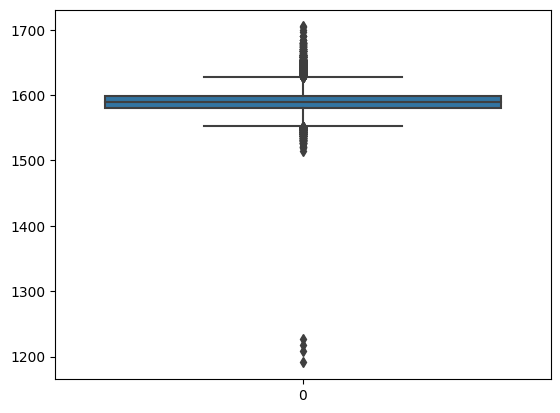

In [24]:
sns.boxplot(temp['Температура'])

Убираем значения менее 1400.00 - это брак. И + 273 градуса, чтобы считать по Цельсию вместо Кельвина. Итого убираем больше 1673:

In [25]:
good_last_temp = good_temp_last[good_temp_last['Температура']<1673]
display(good_last_temp)

good_first_temp = good_temp_first[good_temp_first['Температура']<1673]
display(good_first_temp)

,key,Время замера,Температура
5,1,2019-05-03 11:30:38,1613.0
10,2,2019-05-03 11:55:09,1602.0
16,3,2019-05-03 12:35:57,1599.0
21,4,2019-05-03 12:59:47,1625.0
26,5,2019-05-03 13:36:39,1602.0
...,...,...,...
13903,2495,2019-08-10 11:50:47,1591.0
13910,2496,2019-08-10 12:25:13,1591.0
13914,2497,2019-08-10 12:53:28,1589.0
13920,2498,2019-08-10 13:23:31,1594.0


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
6,2,2019-05-03 11:34:04,1581.0
11,3,2019-05-03 12:06:44,1596.0
17,4,2019-05-03 12:39:27,1601.0
22,5,2019-05-03 13:11:03,1576.0
...,...,...,...
13899,2495,2019-08-10 11:27:47,1570.0
13904,2496,2019-08-10 11:56:48,1554.0
13911,2497,2019-08-10 12:37:26,1571.0
13915,2498,2019-08-10 12:58:11,1591.0


Посчитаем длительность нагрева электродов:

1. переводим дату в нужный формат
2. объединяем таблицы с первым и последним замером
3. переводим длительность в секунды

In [26]:
good_first_temp['Время замера'] = good_first_temp['Время замера'].apply(pd.to_datetime)
good_last_temp['Время замера'] = good_last_temp['Время замера'].apply(pd.to_datetime)

good_first_temp.info()
good_last_temp.info()

<ipython-input-26-135daad8a36b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_first_temp['Время замера'] = good_first_temp['Время замера'].apply(pd.to_datetime)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 13921
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2471 non-null   int64         
 1   Время замера  2471 non-null   datetime64[ns]
 2   Температура   2471 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 5 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           2457 non-null   int64         
 1   Время замера  2457 non-null   datetime64[ns]
 2   Температура   2457 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.8 KB


<ipython-input-26-135daad8a36b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_last_temp['Время замера'] = good_last_temp['Время замера'].apply(pd.to_datetime)


In [27]:
good_temp = pd.merge(good_last_temp, good_first_temp, on='key')
good_temp = good_temp.rename(columns={'Температура_x': 'Temp_last',
                                      'Температура_y': 'Temp_first',
                                      'Время замера_x': 'Last_time',
                                      'Время замера_y': 'First_time'})

good_temp['measure_time'] = pd.to_datetime(good_temp['Last_time']) - pd.to_datetime(good_temp['First_time'])
good_temp['measure_time'] = good_temp['measure_time'].apply(lambda x: x.total_seconds())

display(good_temp.head())

,key,Last_time,Temp_last,First_time,Temp_first,measure_time
0,1,2019-05-03 11:30:38,1613.0,2019-05-03 11:02:04,1571.0,1714.0
1,2,2019-05-03 11:55:09,1602.0,2019-05-03 11:34:04,1581.0,1265.0
2,3,2019-05-03 12:35:57,1599.0,2019-05-03 12:06:44,1596.0,1753.0
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0,1220.0
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0,1536.0


**Данные о проволочных материалах, объём:**
- много пропусков и незаполненных данных. Похоже, проволока не понадобилась в партии.
- больше всего заполненных данных в 1 и 2 партии,
- всего было 9 партий, средние показатели каждой партии разные. Скорее всего это связяно с отсутствием данных.

In [28]:
wire = pd.read_csv('/content/data_wire_new (1).csv')
display(wire.head(10))
wire.info()
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Уберем данные меньше 500 значений:

In [29]:
wire_ok = wire[['key', 'Wire 1', 'Wire 2']]
wire_ok.fillna(0, inplace=True)

display(wire_ok)

<ipython-input-29-2b15a48b87ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wire_ok.fillna(0, inplace=True)


,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456
...,...,...,...
3076,3237,38.088959,0.00000
3077,3238,56.128799,0.00000
3078,3239,143.357761,0.00000
3079,3240,34.070400,0.00000


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

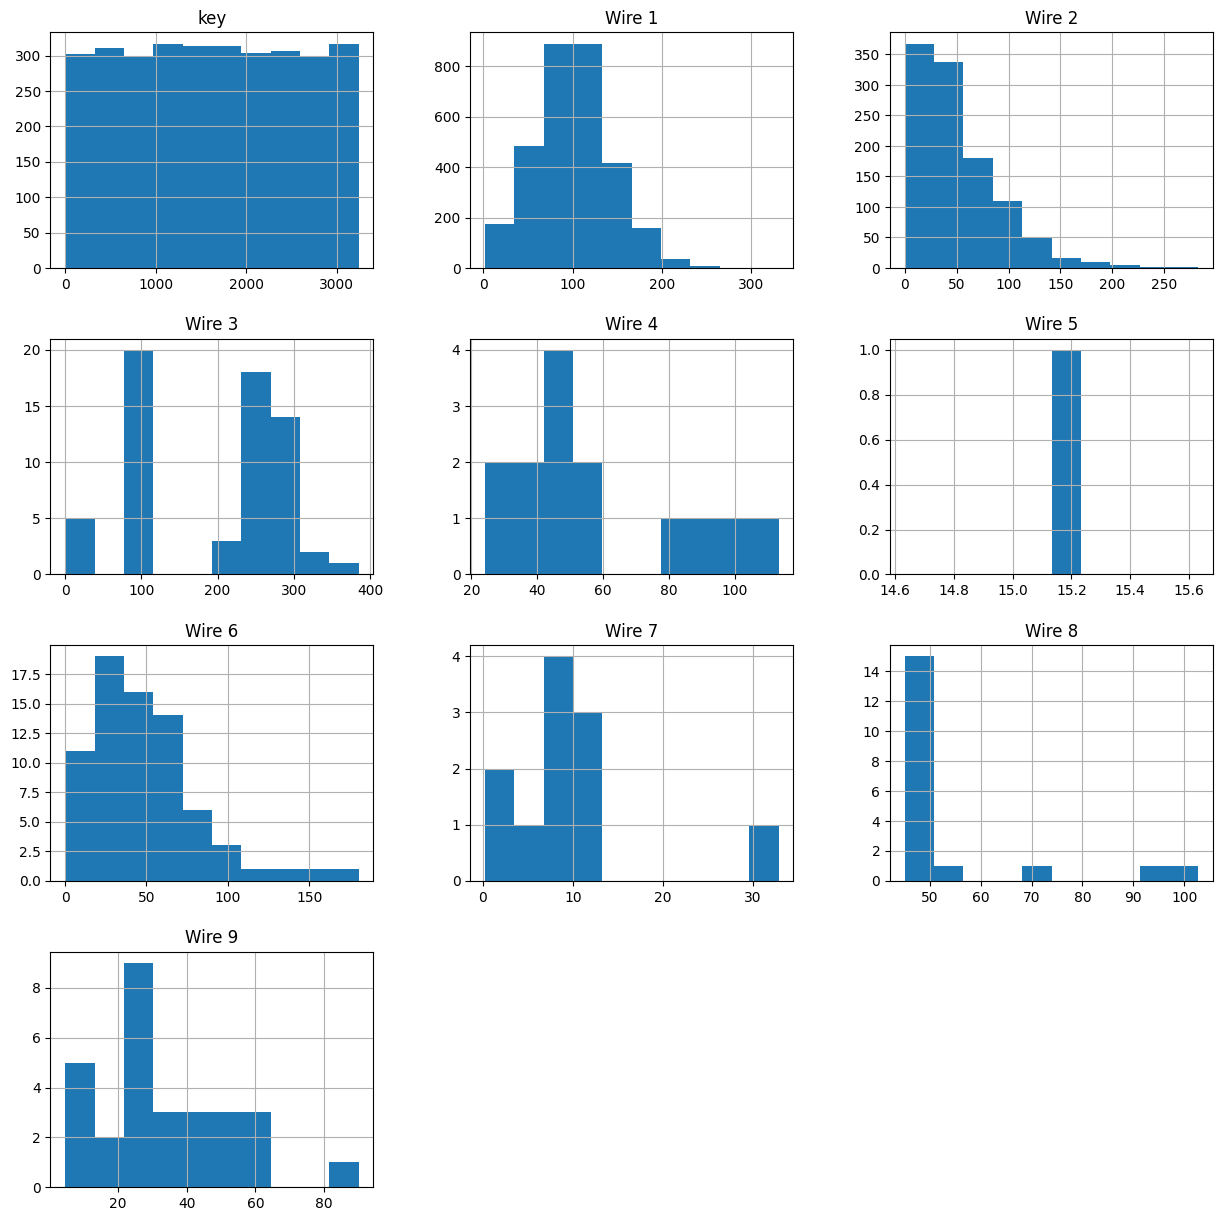

In [30]:
wire.hist(figsize=(15, 15));

wire.isna().sum()

**Данные о проволочных материалах, время:**
- ожидаемо данные есть только в тех случаях, когда была партия.

Описательная статистика здесь не инфомративна. Для построения графика нужно переводить данные в другой формат. Не ясно пригодятся ли мне для прогнозирования эти данные. Оставляю как есть.

In [31]:
wire_time = pd.read_csv('/content/data_wire_time_new (1).csv', index_col=[0], parse_dates=[0])
display(wire_time.sample(10))
wire_time.info()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
550,2019-05-24 11:41:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296,2019-06-21 09:16:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2999,2019-08-29 09:08:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552,2019-06-30 21:18:26,2019-06-30 21:12:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2967,2019-08-28 06:39:25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,2019-05-10 23:49:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
889,2019-06-06 22:51:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1536,2019-06-30 10:46:53,2019-06-30 10:38:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
851,2019-06-05 17:44:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Wire 1  3055 non-null   object
 1   Wire 2  1079 non-null   object
 2   Wire 3  63 non-null     object
 3   Wire 4  14 non-null     object
 4   Wire 5  1 non-null      object
 5   Wire 6  73 non-null     object
 6   Wire 7  11 non-null     object
 7   Wire 8  19 non-null     object
 8   Wire 9  29 non-null     object
dtypes: object(9)
memory usage: 240.7+ KB


In [32]:
wire_time.isna().sum()

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

### Итог:

1. 7 датасетов описывают один этап обработки стали.
2. В нем задействовано около 15 000 электродов.
3. Подача сыпучих материалов осуществлялась 15 раз.
4. подача проволоки осуществлялась 9 раз.
5. В п.2 и 3 много пропусков данных. Учитывая описание, предполагаю, что добавление на разных этапах обходимо не всегда: состав доводят на нужных показателей.
6. Средняя температура плавления 1600 градусов.
7. Судя по количеству продувов, материалы добавляли более 3 000 раз.

## Предобработка данных

Соединяем данные в один датасет:

In [33]:
data = pd.merge(good_temp, good_arc, on='key')

In [34]:
data = pd.merge(data, bulk_ok, on='key')

In [35]:
data = pd.merge(data, gas, on='key')

In [36]:
data = pd.merge(data, wire_ok, on='key')

In [37]:
good_data = data.drop(['Last_time', 'First_time'], axis=1)

In [38]:
good_data = good_data.rename(columns={'Газ 1': 'Gas'})
display(good_data.head())
good_data.info()

,key,Temp_last,Temp_first,measure_time,full_power,work_power,work_arc,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Gas,Wire 1,Wire 2
0,1,1613.0,1571.0,1714.0,3.716640,295.428150,687.578351,0.0,43.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
1,2,1602.0,1581.0,1265.0,2.586371,313.566812,444.855752,0.0,73.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
2,3,1599.0,1596.0,1753.0,5.014163,130.629974,1830.169539,0.0,34.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
3,4,1625.0,1601.0,1220.0,3.399456,217.976074,503.119438,0.0,81.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
4,5,1602.0,1576.0,1536.0,2.815155,308.686385,385.676226,0.0,78.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2329 non-null   int64  
 1   Temp_last     2329 non-null   float64
 2   Temp_first    2329 non-null   float64
 3   measure_time  2329 non-null   float64
 4   full_power    2329 non-null   float64
 5   work_power    2329 non-null   float64
 6   work_arc      2329 non-null   float64
 7   Bulk 3        2329 non-null   float64
 8   Bulk 4        2329 non-null   float64
 9   Bulk 6        2329 non-null   float64
 10  Bulk 12       2329 non-null   float64
 11  Bulk 14       2329 non-null   float64
 12  Bulk 15       2329 non-null   float64
 13  Gas           2329 non-null   float64
 14  Wire 1        2329 non-null   float64
 15  Wire 2        2329 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 309.3 KB


In [39]:
good_data.corr()

,key,Temp_last,Temp_first,measure_time,full_power,work_power,work_arc,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Gas,Wire 1,Wire 2
key,1.000000,-0.097242,-0.019186,-0.019994,-0.022712,-0.002999,-0.012765,-0.007271,-0.026147,0.006241,0.025958,-0.110275,-0.045531,-0.043486,-0.013564,0.043149
Temp_last,-0.097242,1.000000,0.252443,0.096505,0.175718,0.118076,0.109981,-0.035977,0.187970,-0.181816,0.267424,0.114617,0.266414,0.059160,0.317575,-0.206672
Temp_first,-0.019186,0.252443,1.000000,0.180590,-0.120176,-0.258516,-0.061193,-0.104394,0.144775,-0.096951,-0.058495,-0.131024,-0.040349,0.037341,0.209444,-0.086089
measure_time,-0.019994,0.096505,0.180590,1.000000,0.538753,0.009691,0.261652,0.023383,0.002352,0.154504,0.210284,0.174506,0.099961,0.439339,0.153560,0.060035
full_power,-0.022712,0.175718,-0.120176,0.538753,1.000000,-0.297797,0.540866,0.102615,0.005236,0.132827,0.286434,0.299091,0.169513,0.370535,0.138314,0.062346
work_power,-0.002999,0.118076,-0.258516,0.009691,-0.297797,1.000000,-0.155642,-0.009628,-0.036569,0.032939,0.252590,0.248975,0.189487,0.048196,-0.104096,-0.004271
work_arc,-0.012765,0.109981,-0.061193,0.261652,0.540866,-0.155642,1.000000,0.069294,0.014872,0.059883,0.133929,0.171090,0.087039,0.214975,0.053031,0.025140
Bulk 3,-0.007271,-0.035977,-0.104394,0.023383,0.102615,-0.009628,0.069294,1.000000,-0.295431,0.065284,0.018371,0.010772,-0.012860,0.059628,0.039637,0.095723
Bulk 4,-0.026147,0.187970,0.144775,0.002352,0.005236,-0.036569,0.014872,-0.295431,1.000000,-0.251562,0.105791,-0.090602,0.101514,0.017578,0.297591,-0.268142
Bulk 6,0.006241,-0.181816,-0.096951,0.154504,0.132827,0.032939,0.059883,0.065284,-0.251562,1.000000,-0.112902,0.177490,-0.109316,0.139625,-0.235793,0.204627


## Подготовка данных к обучению моделей. Обучение моделей.

In [40]:
train, test = train_test_split(good_data, random_state = RANDOM_STATE, test_size=0.25)

features_train = train.drop(['key', 'Temp_last'], axis=1)
target_train = train['Temp_last']
features_test = test.drop(['key', 'Temp_last'], axis=1)
target_test = test['Temp_last']

for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)

(1746, 14)
(1746,)
(583, 14)
(583,)


### Подбираем гиперпараметры для моделей:

**Линейная регрессия**

In [41]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

scores = cross_val_score(model_lr, features_train, target_train, cv=7,
                         scoring='neg_mean_absolute_error').mean() * -1


print(scores)

6.869574609405655
CPU times: user 110 ms, sys: 58.5 ms, total: 169 ms
Wall time: 279 ms


**Случайный лес**

In [42]:
%%time

rf = RandomForestRegressor(random_state = RANDOM_STATE)


params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30]}

rf = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=50, cv=10, verbose=200, n_jobs = -2)
rf.fit(features_train, target_train)


pred_train = rf.predict(features_train)
mae = mean_absolute_error(target_train, pred_train)


print(f'Лучшие параметры: {rf.best_params_}')
print(f'MAE: {mae}')

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10; 1/9] START max_depth=10, n_estimators=100.............................


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/10; 1/9] END max_depth=10, n_estimators=100;, score=0.318 total time=   2.0s
[CV 2/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 2/10; 1/9] END max_depth=10, n_estimators=100;, score=0.396 total time=   2.5s
[CV 3/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 3/10; 1/9] END max_depth=10, n_estimators=100;, score=0.465 total time=   3.0s
[CV 4/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 4/10; 1/9] END max_depth=10, n_estimators=100;, score=0.147 total time=   3.5s
[CV 5/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 5/10; 1/9] END max_depth=10, n_estimators=100;, score=0.339 total time=   2.5s
[CV 6/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 6/10; 1/9] END max_depth=10, n_estimators=100;, score=0.227 total time=   2.7s
[CV 7/10; 1/9] START max_depth=10, n_estimators=100.............................
[CV 7/10; 1/9] E

**CatBoostRegressor**

In [43]:
%%time
model = CatBoostRegressor()

params = {
    "learning_rate": [0.01, 0.03,  0.06, 0.1],
    "iterations": np.arange(50, 301, 10),
    "depth": [3, 5, 6, 7]
}

random_search = RandomizedSearchCV(estimator = model,
                                   param_distributions = params,
                                   scoring = 'neg_mean_absolute_error',
                                   cv = 10, n_iter = 10,
                                   random_state = RANDOM_STATE,
                                   n_jobs = -2)

random_search.fit(features_train, target_train)

print('Лучшие гиперпараметры для модели:', (random_search.best_params_))
print('MAE для CatBoostRegressor:', (random_search.best_score_*-1))

Выходные данные были обрезаны до нескольких последних строк (5000).
124:	learn: 7.5235403	total: 197ms	remaining: 260ms
125:	learn: 7.5042947	total: 198ms	remaining: 258ms
126:	learn: 7.4854074	total: 199ms	remaining: 256ms
127:	learn: 7.4737767	total: 201ms	remaining: 254ms
128:	learn: 7.4637180	total: 202ms	remaining: 252ms
129:	learn: 7.4528459	total: 204ms	remaining: 251ms
130:	learn: 7.4402291	total: 205ms	remaining: 249ms
131:	learn: 7.4335317	total: 207ms	remaining: 247ms
132:	learn: 7.4230081	total: 208ms	remaining: 245ms
133:	learn: 7.4149186	total: 209ms	remaining: 243ms
134:	learn: 7.4062439	total: 210ms	remaining: 242ms
135:	learn: 7.3976459	total: 212ms	remaining: 240ms
136:	learn: 7.3822459	total: 213ms	remaining: 238ms
137:	learn: 7.3718195	total: 214ms	remaining: 236ms
138:	learn: 7.3636298	total: 215ms	remaining: 234ms
139:	learn: 7.3489276	total: 217ms	remaining: 232ms
140:	learn: 7.3450265	total: 218ms	remaining: 230ms
141:	learn: 7.3313962	total: 219ms	remaining: 22

## Выбор лучшей модели и тестирование.

In [44]:
%%time

model_test = RandomForestRegressor(n_estimators=200,
                                   max_depth=20,
                                   )

model_test.fit(features_train, target_train)
pred_test = model_test.predict(features_test)

mae_test = mean_absolute_error(target_test, pred_test)
print('МАЕ на тестовой выборке:', mae_test)

МАЕ на тестовой выборке: 6.492739925985418
CPU times: user 3.74 s, sys: 5.73 ms, total: 3.75 s
Wall time: 3.79 s


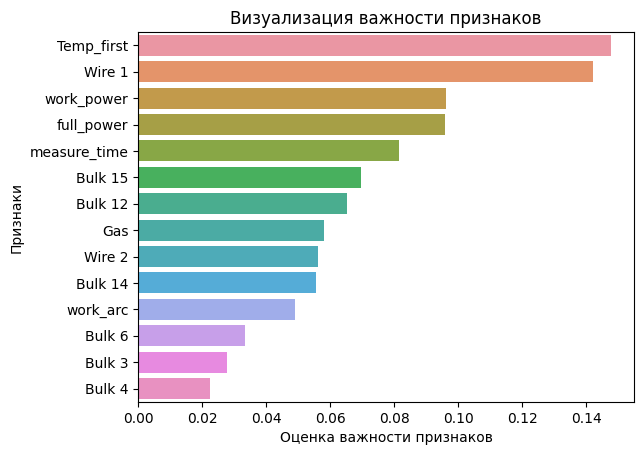

In [45]:

def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_test)


## Выводы

**Подготовка данных:**

1. ✅ Подготовила все необходимые библиотеки для работы:
- графики,
- pandas, numpy,
- модели машинного обучения и их проверка на качество,
- подбор гиперпараметров.

2. ✅ Работа с датасетами. Анализ и предобработка данных:
- получила общую информацию о данных (head, info, describe, графический анализ),
- переименовала некоторые столбцы на английский,
- **температура**  тут находится целевая. Удалила пустые значения и значения, в которых указана одна температура ковша + температура выше 1673 градуса по Цельсию (брак). Привела столбцы со временем к нужному формату. Для основного датасета взяла даннные о первой и последней температуре нагрева ковша, длительность нагрева ковша.
- **электроды, нагрев** с датасетом пришлось потрудиться. Не имеет пропусков, есть аномалия в реактивной мощности - убрала. Привела столбцы со временем к нужному формату. Из не получила данные полной мощности, длительность нагрева, длительность работы электродов. Для получения МАЕ < 6,8 эти данные оказались ключевыми, их все добавила в основной датасет.
- **газ** самый идеальный датасет. Без пропусков, аномалий и имеет один показатель на ковш.
- **сыпучие материалы и проволока** решила объединить, так как принцип работы с ними был одинаковый. Удалила присыпки, в которых было меньше 500 значений. В тех, что остались пустые значения заменила на "0". Их добавила в основной датасет.
- **сыпучие материалы и проволока, время** не использовала в работе, так как время присыпки нас не интересовало. От него ничего не зависело.

3. ✅ Основной датасет. Собрала все необходимые даныне и соединила 5 датасетов по 'key' в один. Итоговые столбцы:
- key - ковш,
- Temp_last	- финальная температура ковша, при которой получается ОК-сталь,
- Temp_first - начальная температура ковша, с которой начинается его нагрев,
- measure_time - средняя длительность нагрева ковша в секундах,
- full_power - полная мощность работы электродов,
- work_power - работа электродов,
- work_arc - мощность работы электродов,
- Bulk 3, Bulk 4, Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2 - присыпки сып.материалов и проволоки,
- Gas - данные о газе.
3.1. Получилось 2329 строки.
3.2. Посмотрела корреляцию данных, все в норме.
❌ не делела аналитический и графический анализ. Посчитала, что его достаточно в предобработке данных.


4. ✅ Модели. Выбор моделей, подбор гиперпараметров, обучение, тестирование.
- разделила выборку на тренировочную и тестовую в отношении 75/25. Удалила данные о времени и ковша - они не являются признаками для обучения.
- для обучения выбрала 2 простых модели регрессии LinearRegression, RandomForestRegressor и одну буст-модель CatBoostRegressor,
- для подбора гиперпараметров выбрала RandomizedSearchCV.
❌ не делала масштабирование данных, не пригодилось
❌ не делала константную модель. Надо вспомнить как с ней работать :)
- лучше всего показала на тренировочной выборке себя RandomForestRegressor: МАЕ-2,5. За это выбрала ее для тестирования.
- на тесте RandomForestRegressor показала МАЕ-6,4. Это меньше заявленных 6,8, так что модель годна для работы.
- анализ важности показал, что на первом месте стоит фактор температуры. След.важный фактор - первая присыпка проволоки. Есть общее впечатление, что важность фактора зависит от количества данных(суммы).

5. ✅ Общий вывод.
- из 7 датасетов получился один рабочий,
- есть данные, которые не понадобились для обучения моделей - это время присыпок,
- в целевой "температура" были убраны неполные ковши и ковши с одним значением и с нагревом более 1673 градуса (брак),
- пустые значения присыпок заполнены "0", так как эти данные означают, что присыпок при опред.температуре не было. Они нам нужны для обучения,
- сборный датасет был разделен на трен.и тест выбоки. Для обучения взяты 3 модели.
- для теста взята модель с лучшими параметрами RandomForestRegressor. Она же показала на тесте МАЕ-6,4. что означает: модель годна для работы.

### Итоговая модель и ее качество:

**RandomForestRegressor** показала лучшие результаты.
- МАЕ 2,5 на тестовой выборке.
- МАЕ 6,4 на тестовой выборке.

### Список признаков обучения и описание их предобработки:

1. Temp_last - финальная температура ковша, при которой получается хороший состав стали. Сгруппировала даннные по ковшам в датасете с температурой и сохранила от них последнюю. Предварительно удалив ковши с 1 показателем и пустые.
2. Temp_first - начальная температура ковша, с которой начинается его нагрев. Сгруппировала даннные по ковшам в датасете с температурой и сохранила от них первую. Предварительно удалив ковши с 1 показателем и пустые.
3. measure_time - средняя длительность нагрева ковша в секундах. Это разница между концом и началом нагрева ковша.
4. full_power - полная мощность работы электродов. Корень из суммы активной и реактивной мощности в квадрате датасета с электродами.
5. work_power - работа электродов. Время работы поделеное на полную мощность.
6. work_arc - мощность работы электродов,
7. Bulk 3, Bulk 4, Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2 - присыпки сып.материалов и проволоки. Удалила присыпки, в которых было меньше 500 значений. В тех, что остались пустые значения заменила на "0".
8. Gas - данные о газе. Без предобработки.

### Гиперпараметры лучшей модели:

**Модель:** model = RandomForestRegressor()
**Гиперпараметры:** n_estimators=200, max_depth=20.

### Рекомендации по улучшению модели:

1. Обучить другие модели.
2. Объедить сып.материалы в один столбец, то же сделать с проволокой.
3. Добавить среднюю температуру ковша.
4. Сделать масштабирование данных.
5. Все-таки поискать взаимосвязь времени присыпок к их количеству и температуре, газу.